In [1]:
import pandas as pd
import numpy as np
import random 
import os
import json

from sklearn.preprocessing import MinMaxScaler

pd.set_option('display.max_rows', 50)


from functions import sharpe_ratio_calculation, generate_rand_portfolios, select_top_five, join_stocks_crypto, evaluate_clustering_stability, run_clustering_model

c:\Users\Kirill\Documents\Projects\thesis\venv312\Lib\site-packages\tslearn\bases\bases.py:15: UserWarning: h5py not installed, hdf5 features will not be supported.
Install h5py to use hdf5 features: http://docs.h5py.org/
  warn(h5py_msg)


In [2]:
df_all_stocks = pd.read_csv('stocks_data_FINAL.csv',index_col='Date')
df_all_stocks.index = pd.to_datetime(df_all_stocks.index)
df_all_stocks.index = df_all_stocks.index.strftime('%Y-%m-%d')

cryptos_df = pd.read_csv('cryptos_data_new.csv', index_col='timestamp')

joined_df = join_stocks_crypto(cryptos_df, df_all_stocks, mode = 'stocks_left') #mode - either do left with crypto and fill NA for stocks or do left on stocks and leave out some dates for cryptos
joined_df.index = pd.to_datetime(joined_df.index)

joined_df_weekly = joined_df.resample('W').last() #aggregating on a weekly level
joined_df_3days = joined_df.resample('3D').last()# aggregating on a twice per week basis to arrive at the sweet spot of that 250 (1 year) timeseries length

In [3]:
#Random Portfolios generation
tickers = list(df_all_stocks.columns)

random.seed(42)
random_portfolios = generate_rand_portfolios(n_reps=1000, n_stocks=15, tickers=tickers)

#Select top five sharpe ratio portfolios from a portfolio
sharpe_ratio = sharpe_ratio_calculation(df_all_stocks, rf_rate_annual = 0.02)
top_five_dict = select_top_five(random_portfolios, metric=sharpe_ratio)

In [40]:
##############TEST###################
from functions import test_clustering_metrics
random.seed(42)


n_clusters_list = [4,7,9,10,12,15,18]
df_with_label_balance = pd.DataFrame()
linkage_list = ['average', 'complete', 'single']
method = 'kshape'
for window in [1,7,10,14,30,60]:
    for df_dict in [{'weekly': joined_df_weekly}, {'3day': joined_df_3days}, {'full': joined_df}]:
        if method != 'ahc':
            linkage_list = None
        print(f'Doing window size {window} with {list(df_dict.keys())[0]} aggregation')
        output = test_clustering_metrics(df_dict, n_clusters_list, method=method, linkage_list=linkage_list, 
                               return_mode='geometric', window=window, n_init=3)
        df_with_label_balance = pd.concat([df_with_label_balance, output])

df_with_label_balance.to_csv(f'NEW_CLUSTERING_TUNING_FINAL/{method}.csv', index=False)

Doing window size 1 with weekly aggregation
Doing window size 1 with 3day aggregation
Doing window size 1 with full aggregation
Doing window size 7 with weekly aggregation
Doing window size 7 with 3day aggregation
Doing window size 7 with full aggregation
Doing window size 10 with weekly aggregation
Doing window size 10 with 3day aggregation
Doing window size 10 with full aggregation
Doing window size 14 with weekly aggregation
Doing window size 14 with 3day aggregation
Doing window size 14 with full aggregation
Doing window size 30 with weekly aggregation
Doing window size 30 with 3day aggregation
Doing window size 30 with full aggregation
Doing window size 60 with weekly aggregation
Doing window size 60 with 3day aggregation
Doing window size 60 with full aggregation


In [51]:
kmeans_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/kmeans.csv')
kshape_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/kshape.csv')
ahc_results = pd.read_csv('NEW_CLUSTERING_TUNING_FINAL/ahc.csv')

results = pd.concat([ahc_results, kshape_results, kmeans_results])

In [52]:
# Normalize silhouette scores and entropy (higher is better)
results[['silhouette_norm']] = MinMaxScaler().fit_transform(results[['silhouette_score']])
results['entropy_norm_clusters'] = results['entropy'] / np.log2(results['clusters']) #normalize relative to the K clusters


# Filter on only strong silhouette values and reasonable entropy
results_filtered = results[results['silhouette_norm'] > 0.7]
results_filtered = results_filtered[results_filtered['entropy_norm_clusters'] > 0.5]

# Compute total score: average of silhouette and normalized entropy
results_filtered['total_score'] = (results_filtered['silhouette_norm'] + results_filtered['entropy_norm_clusters']) / 2



# Get best config per method
# best_configs = results_filtered.loc[
#     results_filtered.groupby('method')['total_score'].idxmax()
# ].sort_values(by='total_score', ascending=False)

In [53]:
#Then we can sort by either silhouette and then entropy or by total score
results_filtered#.sort_values(['silhouette_norm'], ascending=False).head(5)

,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,silhouette_norm,entropy_norm_clusters,total_score
126,4,0.139346,ahc,average,geometric,10,weekly,NaN,1.3485,0.716342,0.674250,0.695296
196,4,0.130924,ahc,complete,geometric,14,weekly,NaN,1.8867,0.700634,0.943350,0.821992
252,4,0.282137,ahc,average,geometric,30,weekly,NaN,1.0081,0.982636,0.504050,0.743343
253,7,0.155869,ahc,average,geometric,30,weekly,NaN,1.8419,0.747155,0.656098,0.701626
254,9,0.143359,ahc,average,geometric,30,weekly,NaN,1.9282,0.723826,0.608279,0.666053
...,...,...,...,...,...,...,...,...,...,...,...,...
106,7,0.143235,kmeans,not_applicable,geometric,60,weekly,5.263665,2.6175,0.723595,0.932372,0.827984
112,4,0.204033,kmeans,not_applicable,geometric,60,3day,15.257658,1.9605,0.836978,0.980250,0.908614
114,9,0.144107,kmeans,not_applicable,geometric,60,3day,12.105328,2.9438,0.725221,0.928666,0.826943
115,10,0.144019,kmeans,not_applicable,geometric,60,3day,11.292577,3.2069,0.725057,0.965373,0.845215


In [54]:
#IF WE WANTED TO IGNORE STABILITY AND ECONOMIC FACTOR:
best_configs = results_filtered.loc[
    results_filtered.groupby('method')['total_score'].idxmax()
].sort_values(by='total_score', ascending=False)

best_configs

,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,silhouette_norm,entropy_norm_clusters,total_score
105,4,0.258292,kmeans,not_applicable,geometric,60,weekly,6.136760,1.7920,0.938166,0.8960,0.917083
14,4,0.198238,kshape,not_applicable,geometric,1,full,0.216184,1.9232,0.826171,0.9616,0.893886
322,4,0.240640,ahc,complete,geometric,60,weekly,NaN,1.7236,0.905246,0.8618,0.883523


In [55]:
#CLUSTERING STABILITY
filtered_results_with_stability = results_filtered.copy()
for row in filtered_results_with_stability.iterrows():

    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        agg_level = 3
    elif row[1]['df_mode'] == 'weekly':
        agg_level = 5
    else:
        agg_level = 1

    results = evaluate_clustering_stability(joined_df, n_clusters=n_clusters, window_size=252, step_size=30, agg_level=agg_level, smoothing_window=window_size, method=method, linkage=linkage)
    if len(results) > 20:
        break
    ari_mean = results['ari'].mean()
    nmi_mean = results['nmi'].mean()

    filtered_results_with_stability.loc[row[0], 'ari_mean'] = ari_mean
    filtered_results_with_stability.loc[row[0], 'nmi_mean'] = nmi_mean

filtered_results_with_stability.to_csv('filtered_results_with_stability_NEW.csv')

In [14]:
filtered_results_with_stability = pd.read_csv('filtered_results_with_stability_NEW.csv')
filtered_results_with_stability['ari_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['ari_mean']])
filtered_results_with_stability['nmi_norm'] = MinMaxScaler().fit_transform(filtered_results_with_stability[['nmi_mean']])
filtered_results_with_stability['stability_score'] = (filtered_results_with_stability['nmi_norm'] + filtered_results_with_stability['ari_norm']) / 2

xxx = filtered_results_with_stability[filtered_results_with_stability['stability_score'] > 0.5]#.sort_values('entropy_norm_clusters', ascending=False)



In [18]:
best_configs = filtered_results_with_stability.loc[
    filtered_results_with_stability.groupby('method')['total_score'].idxmax()
].sort_values(by='total_score', ascending=False)

best_configs

,Unnamed: 0,clusters,silhouette_score,method,linkage,return_mode,window_size,df_mode,inertia,entropy,silhouette_norm,entropy_norm_clusters,total_score,ari_mean,nmi_mean,ari_norm,nmi_norm,stability_score
79,105,4,0.258292,kmeans,not_applicable,geometric,60,weekly,6.136760,1.7920,0.938166,0.8960,0.917083,0.022222,0.038404,0.010077,0.000000,0.005038
41,14,4,0.198238,kshape,not_applicable,geometric,1,full,0.216184,1.9232,0.826171,0.9616,0.893886,0.825709,0.802946,1.000000,1.000000,1.000000
19,322,4,0.240640,ahc,complete,geometric,60,weekly,NaN,1.7236,0.905246,0.8618,0.883523,0.014043,0.048602,0.000000,0.013339,0.006670


In [ ]:
from sklearn.metrics import v_measure_score

def clustering_v_measure(cluster_dict:dict, class_dict:dict, method:str):
    try:
        methods_clusters = cluster_dict[method]
    except:
        methods_clusters = cluster_dict.copy()

    common = list(set(methods_clusters) & set(class_dict))

    if not common:
        raise ValueError("No overlapping tickers between clustering and class dictionaries.")

    cluster_labels = [methods_clusters[t] for t in common]
    true_labels = [class_dict[t] for t in common]

    v_measure = v_measure_score(true_labels, cluster_labels)
    
    return v_measure

with open('tickers_with_exchanges.json') as f:
    exchanges_dict = json.load(f)

with open('tickers_with_sectors.json') as f:
    sector_dict = json.load(f)

with open('tickers_with_region.json') as f:
    region_dict = json.load(f)

with open('tickers_with_market.json') as f:
    market_dict = json.load(f)


classes_levels = {'exchange': exchanges_dict, 
'sector': sector_dict,
'market': market_dict,
'region': region_dict}


random.seed(42)

df_with_all_results_filtered = filtered_results_with_stability.copy()
for i, row in enumerate(df_with_all_results_filtered.iterrows()):
    method = row[1]['method']
    linkage = row[1]['linkage']
    window_size = row[1]['window_size']
    n_clusters = row[1]['clusters']
    if row[1]['df_mode'] == '3day':
        df = joined_df_3days
    elif row[1]['df_mode'] == 'weekly':
        df = joined_df_weekly
    else:
        df = joined_df
    
    df = df.rolling(window=window_size, center=False).mean().dropna()

    random.seed(42)
    results, tickers_with_labels, _, _ = run_clustering_model(df, n_clus=n_clusters, model_name=method, linkage=linkage, return_mode='geometric', n_init=3)
    for class_name, class_dict in classes_levels.items():
        v_measure = clustering_v_measure(tickers_with_labels, class_dict, method=method)

        col_name = f'{class_name}_v_measure'
        if col_name not in df_with_all_results_filtered.columns:
            df_with_all_results_filtered[col_name] = np.nan
        df_with_all_results_filtered.at[i, col_name] = v_measure



df_with_all_results_filtered.sort_values('market_v_measure', ascending=False).to_csv('RESULTS_WITH_V_MEASURE.csv', index=False)


In [50]:
#FINAL SELECTION
df_with_all_results_filtered = pd.read_csv('RESULTS_WITH_V_MEASURE.csv')
v_measure_cols = [col for col in df_with_all_results_filtered.columns if 'v_measure' in col]
v_measure_cols.remove('exchange_v_measure')
df_with_all_results_filtered = df_with_all_results_filtered.drop(columns=['exchange_v_measure'])


df_with_all_results_filtered['mean_v_measure'] = df_with_all_results_filtered[v_measure_cols].mean(axis=1)
df_with_all_results_filtered['normalized_mean_v_measure'] = MinMaxScaler().fit_transform(df_with_all_results_filtered[['mean_v_measure']])

final_selection_clustering = df_with_all_results_filtered.copy()
# final_selection_clustering = df_with_all_results_filtered[df_with_all_results_filtered['normalized_mean_v_measure'] > 0.5]
# final_selection_clustering = final_selection_clustering[final_selection_clustering['stability_score'] > 0.5]


final_selection_clustering['renormalized_silhouette'] = MinMaxScaler().fit_transform(final_selection_clustering[['silhouette_score']])
final_selection_clustering['renormalized_stability'] = MinMaxScaler().fit_transform(final_selection_clustering[['stability_score']])
final_selection_clustering['renormalized_v_measure'] = MinMaxScaler().fit_transform(final_selection_clustering[['mean_v_measure']])

#final_selection_clustering['renormalized_inertia'] = MinMaxScaler().fit_transform(1 - final_selection_clustering[['inertia']]) #ALSO INVERT INERTIA SCORE TO BE HIGHER = BETTER

final_selection_clustering['final_score'] = final_selection_clustering[['renormalized_silhouette', 'renormalized_stability', 'renormalized_v_measure']].mean(axis=1)

final_selection_clustering.loc[final_selection_clustering['final_score'].idxmax()]

Unnamed: 0                               15
clusters                                  7
silhouette_score                   0.201494
method                               kshape
linkage                      not_applicable
return_mode                       geometric
window_size                               1
df_mode                                full
inertia                            0.171723
entropy                              2.6252
silhouette_norm                    0.832242
entropy_norm_clusters              0.935115
total_score                        0.883679
ari_mean                           0.795767
nmi_mean                           0.800427
ari_norm                           0.963111
nmi_norm                           0.996705
stability_score                    0.979908
sector_v_measure                   0.460893
market_v_measure                   0.767774
region_v_measure                   0.761386
mean_v_measure                     0.663351
normalized_mean_v_measure       

In [25]:
results_to_visualise = results.copy()
results_to_visualise['clusters'] = results_to_visualise['clusters'].astype(str)
results_to_visualise = results_to_visualise.groupby(['method', 'clusters']).agg(silhouette_score = ('silhouette_score', 'mean'), inertia = ('inertia', 'mean'), entropy = ('entropy_norm_clusters', 'mean'))
results_to_visualise

silhouette_score    inertia   entropy
method clusters                                       
ahc    10                0.026416        NaN  0.514493
       12                0.020826        NaN  0.537882
       15                0.010942        NaN  0.561738
       18                0.007071        NaN  0.585049
       4                 0.087316        NaN  0.424832
       7                 0.044420        NaN  0.480808
       9                 0.031489        NaN  0.504789
kmeans 10                0.056444  38.129554  0.957620
       12                0.045849  37.077460  0.934860
       15                0.046745  35.604748  0.940661
       18                0.036126  34.265829  0.945938
       4                 0.097649  42.848741  0.950317
       7                 0.061973  40.476264  0.956569
       9                 0.061087  38.717701  0.945986
kshape 10                0.089870   0.095370  0.946748
       12                0.108223   0.087554  0.948170
       15                0.089745   0.078176  0.941327
       18                0.064639   0.071701  0.943727
       4                 0.114284   0.137245  0.973786
       7                 0.109567   0.109867  0.945243
       9                 0.097514   0.098697  0.953161

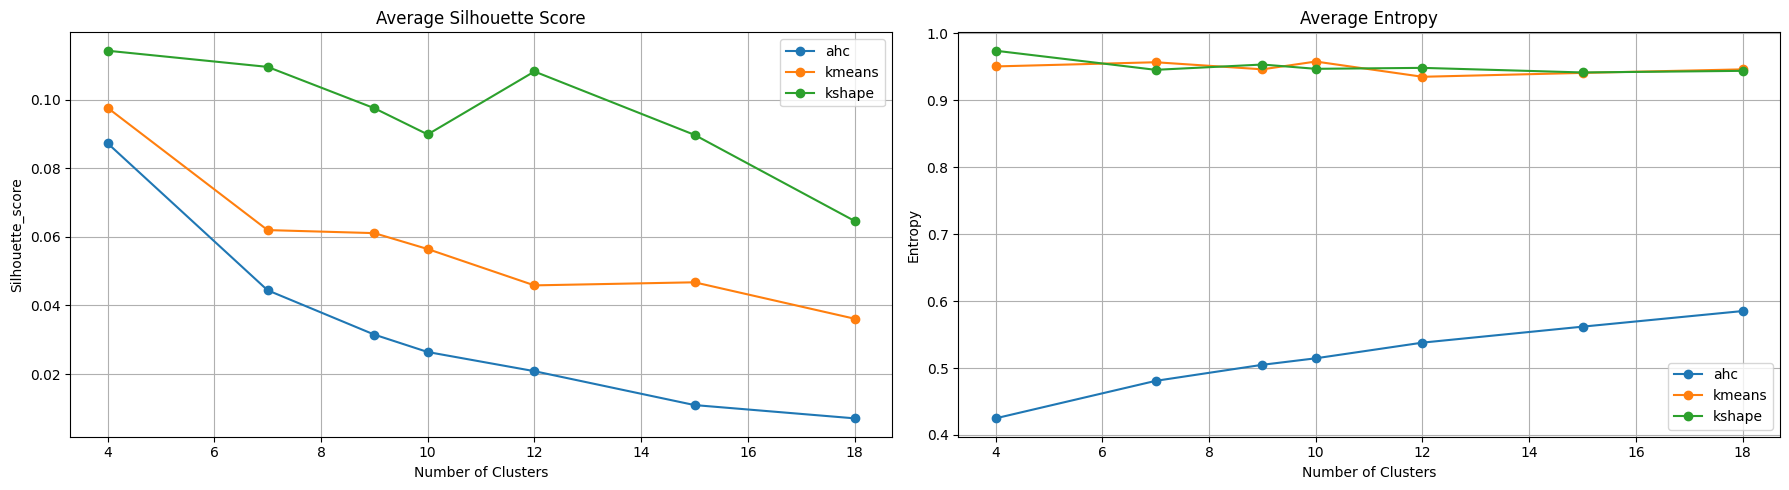

In [26]:
import matplotlib.pyplot as plt

# Your DataFrame (assume it's named df)
# If not already sorted, sort for better visualization
df = results_to_visualise
df = df.reset_index()
df['clusters'] = df['clusters'].astype(int)
df = df.sort_values(by=["clusters", 'method'])
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 5), sharex=True)

metrics = ['silhouette_score', 'entropy']
titles = ['Average Silhouette Score', 'Average Entropy']
colors = {'ahc': 'tab:blue', 'kmeans': 'tab:orange', 'kshape': 'tab:green'}

for ax, metric, title in zip(axes, metrics, titles):
    for method in df['method'].unique():
        subset = df[df['method'] == method]
        ax.plot(subset['clusters'], subset[metric], marker='o', label=method, color=colors[method])
    
    ax.set_title(title)
    ax.set_xlabel("Number of Clusters")
    ax.set_ylabel(metric.capitalize())
    ax.grid(True)
    ax.legend()

plt.tight_layout()
plt.show()


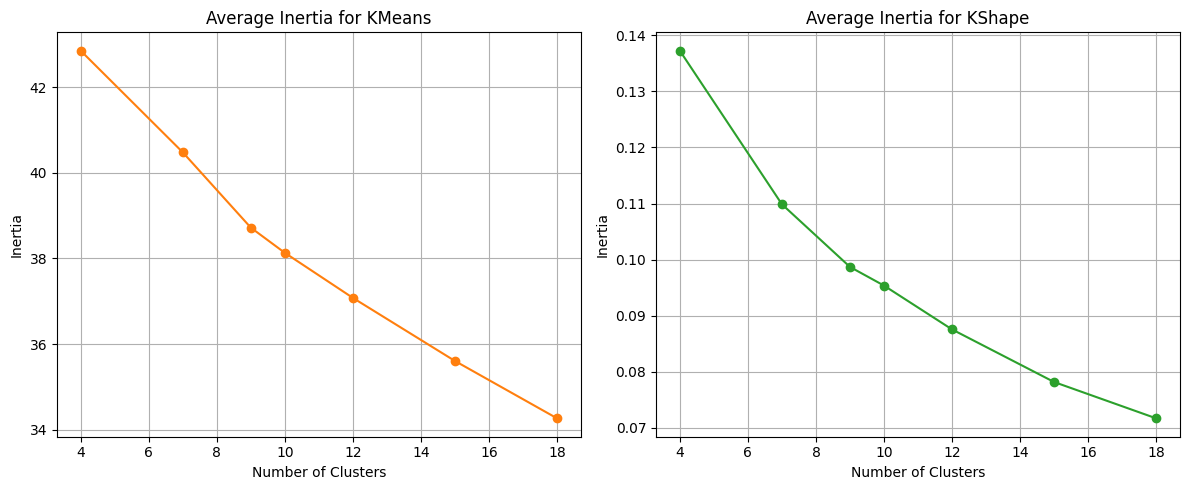

In [27]:
# Filter and sort the DataFrame
df_kmeans = df[df['method'] == 'kmeans'].sort_values(by='clusters')
df_kshape = df[df['method'] == 'kshape'].sort_values(by='clusters')

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot for KMeans
axes[0].plot(df_kmeans['clusters'], df_kmeans['inertia'], marker='o', color='tab:orange')
axes[0].set_title("Average Inertia for KMeans")
axes[0].set_xlabel("Number of Clusters")
axes[0].set_ylabel("Inertia")
axes[0].grid(True)

# Plot for KShape
axes[1].plot(df_kshape['clusters'], df_kshape['inertia'], marker='o', color='tab:green')
axes[1].set_title("Average Inertia for KShape")
axes[1].set_xlabel("Number of Clusters")
axes[1].set_ylabel("Inertia")
axes[1].grid(True)

plt.tight_layout()
plt.show()
